In [626]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.tri import Triangulation
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
from itertools import product
import colorcet as cc

In [2]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

### Massive type IIA on $S^3\times S^3$

Scanning over the parameters ($u_0,\phi_0$) shows which values are potentially viable for fixed $q_0$:

100%|██████████| 900/900 [00:13<00:00, 66.08it/s] 


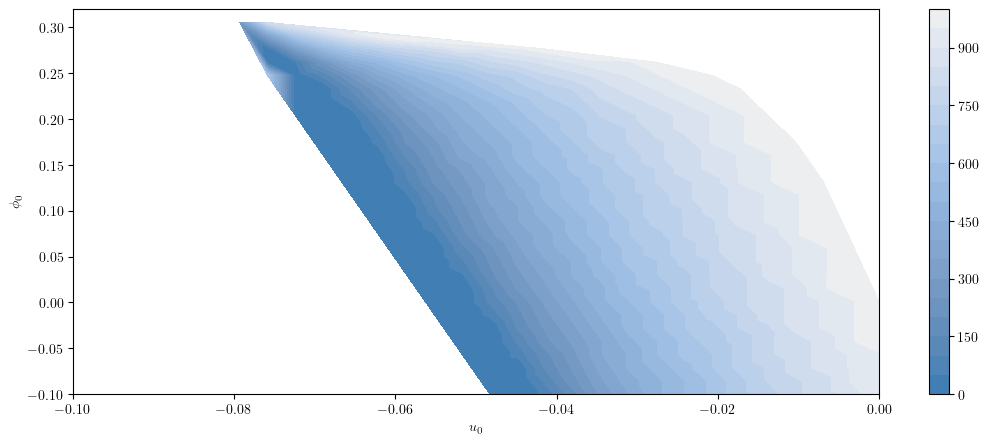

In [107]:
wh.paramScan_S3S3(1, 10, [-0.1, 0], [-0.1, 0.32], 30, 30)

Example profiles upon picking ($u_0,\phi_0$) by hand:

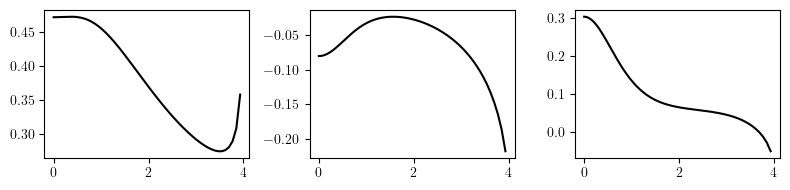

In [109]:
q0, rmax = 1, 10
u0, φ0 = -0.0802, 0.304
soln = wh.solve_S3S3(q0, rmax, u0, φ0)
r, f, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).

Performing shooting method for q0 = 1.00 out to r = 10.00 ... DONE: val_final = 0


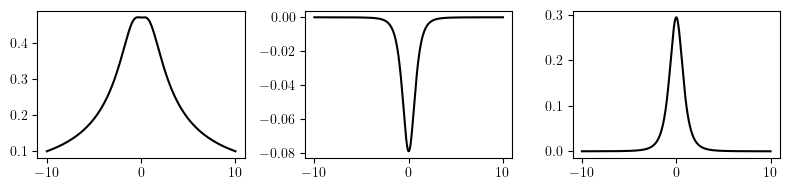

In [13]:
q0, rmax = 1, 10
soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-10, quiet=True)
r, f, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(1, 3, figsize=(8,2), sharex=True)

axes[0].plot(r, f, 'k')
axes[1].plot(r, u, 'k')
axes[2].plot(r, φ, 'k')

plt.tight_layout()
plt.show()

More detailed plot of profiles:

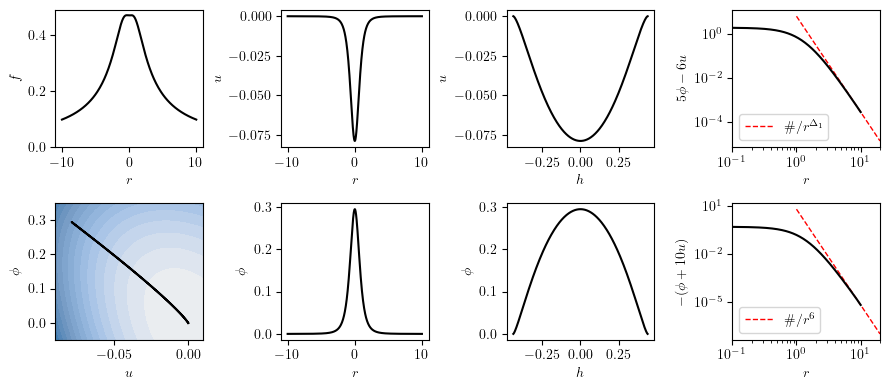

In [112]:
fig, axes = plt.subplots(2, 4, figsize=(9,4))

q = wh.Q(r, q0)

xdata = [r, r, h, r, u, r, h, r]
ydata = [f, u, u, 5*φ-6*u, φ, φ, φ, -(φ+10*u)]
xlabels = ['$r$', '$r$', '$h$', '$r$', '$u$', '$r$', '$h$', '$r$']
ylabels = ['$f$', '$u$', '$u$', '$5\phi-6u$', '$\phi$', '$\phi$', '$\phi$', '$-(\phi+10u)$']


# Plot expected power-law fall-offs in asymptotic region
Δ1 = (3+np.sqrt(33))/2
fcoeff = np.mean(r[-10:]**2 * (f[-10:]**(-2) - (r[-10:]**2 + (1+2*q0**2))))
uφcoeff1 = np.mean(r[-10:]**Δ1 * (5*φ[-10:] - 6*u[-10:]))
uφcoeff2 = np.mean(r[-10:]**6 * (-φ[-10:] - 10*u[-10:]))

rr = np.linspace(q0, 2*rmax, 2)
axes[0,3].plot(rr, uφcoeff1/rr**Δ1, '--r', lw=1, label='$\#/r^{\Delta_1}$')
axes[1,3].plot(rr, uφcoeff2/rr**6, '--r', lw=1, label='$\#/r^6$')

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

# for ax in axes[0]:
#     ax.set_xlim(-10, 10)
axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[1,0].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(φ0s[0], φ0s[-1])


for ax in axes[:,3]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()

# plt.savefig('images/S3S3_profile_example.png', dpi=300)
plt.show()

Field ranges (with comparison to _ad hoc_ replacement $\mathcal{V}\to-6$ where $u,\phi$ are massless):

In [149]:
q0s = np.geomspace(0.0001, 10, 20)

q0s_ml = np.geomspace(q0s[0], q0s[-1], 20)
data_ml = np.asarray([wh.massless_approx_S3S3(q0) for q0 in q0s_ml])
u0s_ml, φ0s_ml, f4s_ml = data_ml.T

data = []

for q0 in q0s:

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-8)
    r, f, u, ud, φ, φd, h, f4sqr = soln

    # It happens that u<0 and φ>0
    data.append([min(u), max(φ), np.sqrt(f4sqr)])

u0s, φ0s, f4s = np.asarray(data).T


Performing shooting method for q0 = 0.0001 out to r = 10 ...
    rmax = 0.0001 with xatol = 0.0001
        f_eval : 118
            u0 : -0.2993062535
            φ0 : +0.6303910603
           val : 9.261458267e-10
    rmax = 0.0316 with xatol = 0.0001
        f_eval : 79
            u0 : -0.782941184
            φ0 : +1.565915033
           val : 1.440308761e-09
    rmax = 10.0000 with xatol = 1e-08
        f_eval : 118
            u0 : -0.7829423009
            φ0 : +1.565899692
           val : 1.532107774e-14

Performing shooting method for q0 = 0.00018329807108324357 out to r = 10 ...
    rmax = 0.0002 with xatol = 0.0001
        f_eval : 118
            u0 : -0.2993062535
            φ0 : +0.6303910603
           val : 9.251988065e-10
    rmax = 0.0428 with xatol = 0.0001
        f_eval : 80
            u0 : -0.7829105945
            φ0 : +1.565812434
           val : 8.97369512e-10
    rmax = 10.0000 with xatol = 1e-08
        f_eval : 116
            u0 : -0.7829072972
       

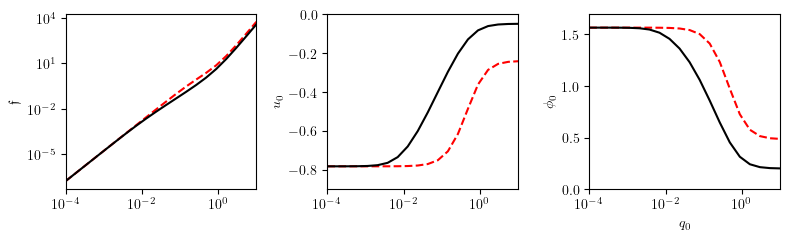

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(8,2.5), sharex=True)

axes[0].plot(q0s_ml, f4s_ml, '--r')
axes[0].plot(q0s, f4s, 'k', ms=3)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\mathfrak{f}$')

axes[1].plot(q0s_ml, u0s_ml, '--r')
axes[1].plot(q0s, u0s, 'k', ms=3)
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)

axes[2].plot(q0s_ml, φ0s_ml, '--r')
axes[2].plot(q0s, φ0s, 'k', ms=3)
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')
plt.xlabel('$q_0$')

plt.tight_layout()
# plt.savefig('images/S3S3_ranges.png', dpi=300)
plt.show()

Flat-space limit


Performing shooting method for q0 = 1.0 out to r = 100 ...
    rmax = 1.0000 with xatol = 0.0001
        f_eval : 98
            u0 : -0.07570750404
            φ0 : +0.2679907332
           val : 1.07982886e-08
    rmax = 10.0000 with xatol = 0.0001
        f_eval : 75
            u0 : -0.07891541747
            φ0 : +0.2942800927
           val : 3.808220613e-06
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 192
            u0 : -0.07891872314
            φ0 : +0.2943216216
           val : 6.661338148e-16

Performing shooting method for q0 = 0.1 out to r = 100 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 113
            u0 : -0.2595244827
            φ0 : +0.6021362378
           val : 1.69582659e-09
    rmax = 3.1623 with xatol = 0.0001
        f_eval : 92
            u0 : -0.359341949
            φ0 : +0.9822359592
           val : 2.120974448e-07
    rmax = 100.0000 with xatol = 1e-12
        f_eval : 213
            u0 : -0.3593439707
            φ0 : +0.

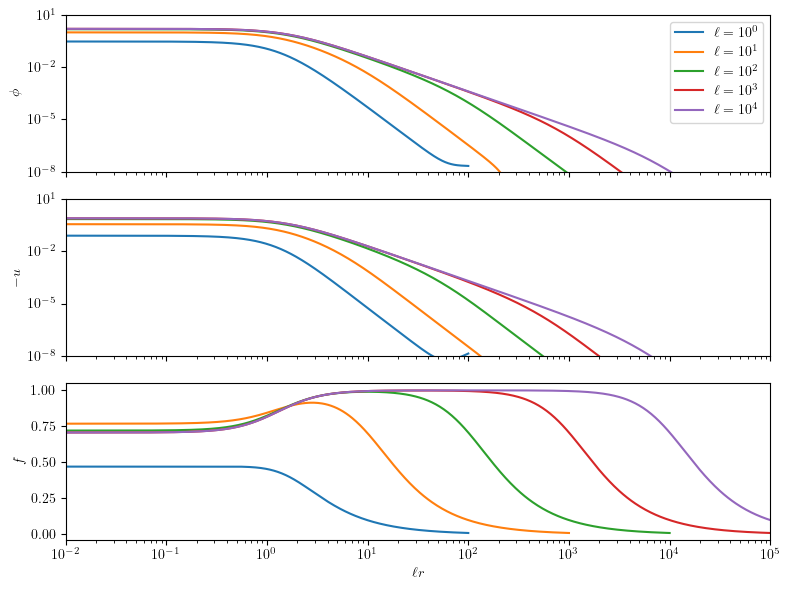

In [105]:
a0 = 1
powers = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in powers:
    l = 10**power
    q0 = a0 / l
    
    rmax = 100
    soln = wh.wormhole_S3S3(q0, rmax, xatol=10**-12)
    r, f, u, ud, φ, φd, h, f4sqr = soln

    q = wh.Q(r, q0)

    axes[0].plot(l*r, φ, label='$\ell=10^{}$'.format(power))
    axes[1].plot(l*r, -u)
    axes[2].plot(l*r, f)

plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylim(10**-8, 10)
axes[0].set_yscale('log')
axes[0].set_ylabel('$\phi$')
axes[0].legend()

axes[1].set_ylim(10**-8, 10)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylabel('$f$')

plt.tight_layout()
plt.savefig('images/S3S3_flat_limit.png', dpi=300)
plt.show()

### Type IIB on $T^{1,1}$

Scanning over the parameters ($u_0,v_0$) shows which values are potentially viable for fixed $q_0$ and $\chi_0'$:

100%|██████████| 400/400 [01:06<00:00,  6.04it/s]


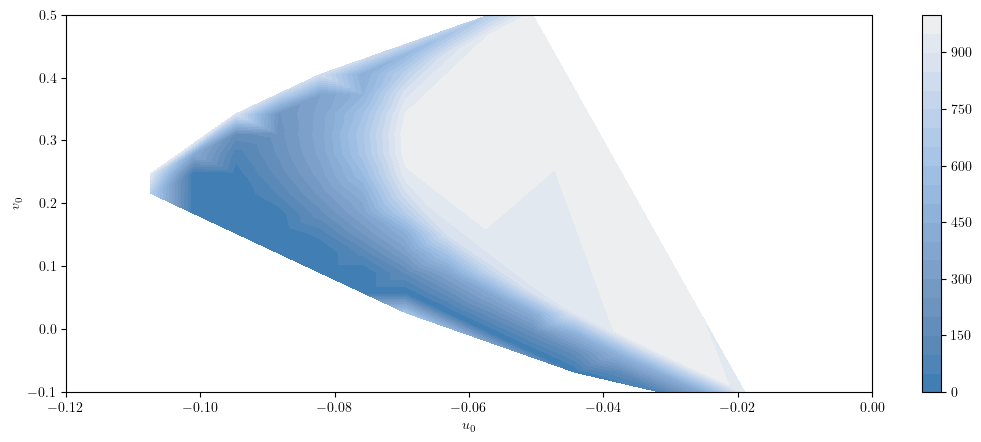

In [152]:
wh.paramScan_T11(1, 0, [-0.12, 0], [-0.1, 0.5], 20, 20, 5)

The optimal solution matching AdS boundary conditions is found using a shooting method. The end-point of the integration is increased in steps up to rmax (using lower precision along the way).

Performing shooting method for q0 = 0.10 and χinf = 0.90 out to r = 10.00 ...
    rmax = 0.1000 with xatol = 0.0001
        f_eval : 294
            u0 : -0.3970058768
            v0 : +0.4485089718
            χ1 : +3.668425556
           val : 0.1320398477

    rmax = 0.3162 with xatol = 0.0001
        f_eval : 130
            u0 : -0.4583436668
            v0 : +0.6629919108
            χ1 : +0.4657457759
           val : 0.06316342163

    rmax = 1.0000 with xatol = 0.0001
        f_eval : 120
            u0 : -0.4584338947
            v0 : +0.6696611351
            χ1 : +0.4099805824
           val : 4.817260357e-08

    rmax = 3.1623 with xatol = 0.0001
        f_eval : 90
            u0 : -0.4584375177
            v0 : +0.6697049299
            χ1 : +0.4100254627
           val : 0.007789679087

    rmax = 10.0000 with xatol = 1e-14
        f_eval : 699
            u0 : -0.458447903
            v0 : +0.6697157433
            χ1 : +0.3729700096
           val : 0



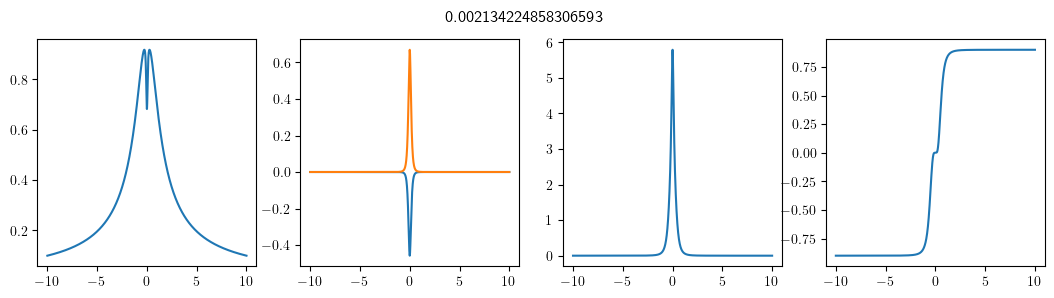

In [144]:
q0 = 0.1
χinf = 0.9
rmax = 10
rmax_steps = 5
soln = wh.wormhole_T11(q0, χinf, rmax, rmax_steps, xatol=10**-14)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2sqr = soln

fig, axes = plt.subplots(1, 4, figsize=(13,3))

axes[0].plot(r, f)
axes[1].plot(r, u)
axes[1].plot(r, v)
axes[2].plot(r, φ)
axes[3].plot(r, χ)

plt.suptitle(flux2sqr)

plt.show()

More detailed plot of profiles:

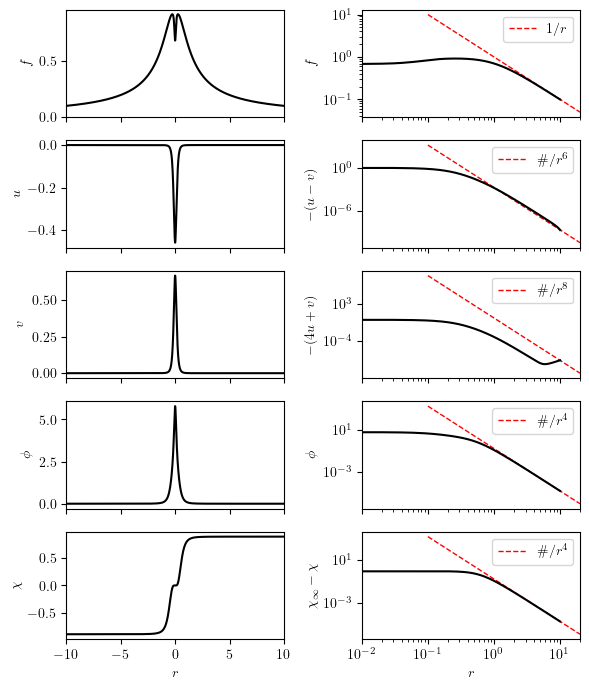

In [145]:
fig, axes = plt.subplots(5, 2, figsize=(6,7), sharex='col')

ydata = [f, f, u, -(u-v), v, -(4*u+v), φ, φ, χ, χinf - χ]
ylabels = ['$f$', '$f$', '$u$', '$-(u-v)$', '$v$', '$-(4u+v)$', '$\phi$', '$\phi$', '$\chi$', '$\chi_\infty-\chi$']


# Plot expected power-law fall-offs in asymptotic region
uvcoeff1 = np.mean(r[-10:]**6 * (-u[-10:] + v[-10:]))
uvcoeff2 = np.mean(r[-10:]**8 * (-4*u[-10:] - v[-10:]))
φ4 = np.mean(r[-10:]**4 * φ[-10:])
χ4 = np.mean(r[-10:]**4 * (χinf - χ[-10:]))


rr = np.linspace(q0, 2*rmax, 2)
axes[0,1].plot(rr, 1/rr, '--r', lw=1, label='$1/r$')
axes[1,1].plot(rr, uvcoeff1/rr**6, '--r', lw=1, label='$\#/r^6$')
axes[2,1].plot(rr, uvcoeff2/rr**8, '--r', lw=1, label='$\#/r^8$')
axes[3,1].plot(rr, φ4/rr**4, '--r', lw=1, label='$\#/r^4$')
axes[4,1].plot(rr, χ4/rr**4, '--r', lw=1, label='$\#/r^4$')

# Plot grid of xy-data
for ax, yy, ylab in zip(axes.ravel(), ydata, ylabels):
    ax.plot(r, yy, 'k')
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

for ax in axes[:,1]:
    ax.set_yscale('log')
    ax.legend()


axes[0,0].set_xlim(-10, 10)
axes[4,1].set_xlim(0.1*q0, 2*rmax)
axes[4,1].set_xscale('log')
axes[4,0].set_xlabel('$r$')
axes[4,1].set_xlabel('$r$')

plt.tight_layout()
# plt.savefig('images/T11_profiles_ex1.png', dpi=300)
plt.show()

#### Field ranges and BPS bound

In [25]:
def powerlaw4(r, a, b, c):
    return np.log(a + b/r**4 + c/r**6)

In [209]:
q0_list = np.geomspace(0.1, 10, 10)

data = np.empty([0, 5])

for q0 in q0_list:

    rmax = max(10, 10*q0)
    rmax_steps = 3

    soln = wh.wormhole_T11(q0, 0.5, rmax, rmax_steps, xatol=10**-10, quiet=True)
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2sqr = soln

    mask = (r > rmax/2)
    poptφ, pcov = curve_fit(powerlaw4, r[mask]/q0, np.log(φ[mask]), p0=[0,1,0])
    poptχ, pcov = curve_fit(powerlaw4, r[mask]/q0, np.log(χ[mask]), p0=[0.5,1,0])
    
    φ4 = poptφ[1] * q0**4
    χinf = poptχ[0]
    χ4 = poptχ[1] * q0**4

    data = np.append(data, [[q0, χinf, flux2sqr, φ4, χ4]], axis=0)

Performing shooting method for q0 = 0.10 and χinf = 0.50 out to r = 10.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.17 and χinf = 0.50 out to r = 10.00 ... DONE: val_final = 1.036549331e-06
Performing shooting method for q0 = 0.28 and χinf = 0.50 out to r = 10.00 ... DONE: val_final = 5.520695012e-12
Performing shooting method for q0 = 0.46 and χinf = 0.50 out to r = 10.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.77 and χinf = 0.50 out to r = 10.00 ... DONE: val_final = 0
Performing shooting method for q0 = 1.29 and χinf = 0.50 out to r = 12.92 ... DONE: val_final = 0
Performing shooting method for q0 = 2.15 and χinf = 0.50 out to r = 21.54 ... DONE: val_final = 0
Performing shooting method for q0 = 3.59 and χinf = 0.50 out to r = 35.94 ... DONE: val_final = 0
Performing shooting method for q0 = 5.99 and χinf = 0.50 out to r = 59.95 ... DONE: val_final = 0
Performing shooting method for q0 = 10.00 and χinf = 0.50 out to r = 100.00 ... DONE: val_

In [221]:
q0s, χinfs, flux2sqrs, φ4s, χ4s = data.T
bps1 = 4*(φ4s + χ4s)/np.sqrt(flux2sqrs) - (1 - χinfs)
bps2 = 4*(φ4s + χ4s)/np.sqrt(flux2sqrs) + (1 - χinfs)

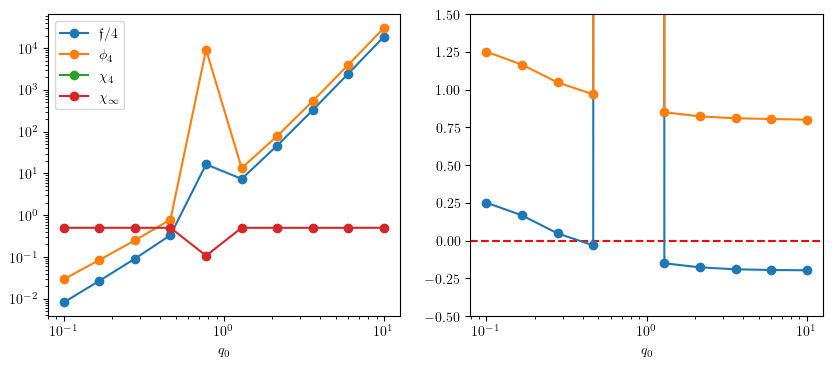

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True)

axes[0].plot(q0s, np.sqrt(flux2sqrs)/4, '-o', label='$\mathfrak{f}/4$')
axes[0].plot(q0s, φ4s, '-o', label='$\phi_4$')
axes[0].plot(q0s, χ4s, '-o', label='$\chi_4$')
axes[0].plot(q0s, χinfs, '-o', label='$\chi_\infty$')

axes[0].set_yscale('log')
axes[0].set_xlabel('$q_0$')
axes[0].legend()

axes[1].axhline(0, ls='--', c='r')
axes[1].plot(q0s, bps1, '-o')
axes[1].plot(q0s, bps2, '-o')
axes[1].set_xlabel('$q_0$')
axes[1].set_ylim(-0.5, 1.5)

plt.xscale('log')

plt.show()

In [156]:
def rmax(q0):
    return max(10, 10*q0)

In [519]:
nr = 1000

q0_data = np.empty([0])
χinfgoal_data = np.empty([0])
r_data = np.empty([0, 2*nr-1])
u_data = np.empty([0, 2*nr-1])
v_data = np.empty([0, 2*nr-1])
φ_data = np.empty([0, 2*nr-1])
χ_data = np.empty([0, 2*nr-1])
χd_data = np.empty([0, 2*nr-1])
flux2_data = np.empty([0])

In [704]:
# q0_list = np.geomspace(0.01, 10, 5)
# χinf_list = np.linspace(0, 0.999, 5)

# for q0, χinf in product(q0_list, χinf_list):

for ii in range(10):
    q0 = 10**(1.6*np.random.rand() - 2)
    χinf = 1 - 0.15 * np.random.rand()

# qχpairs = [[0.02, 0.9], [0.15, 0.87]]
# for q0, χinf in qχpairs:

    rmax_steps = 5
    soln = wh.wormhole_T11(q0, χinf, rmax(q0), rmax_steps, xatol=10**-10, nr=nr, quiet=True)
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2sqr = soln

    r_data = np.append(r_data, [r], axis=0)
    u_data = np.append(u_data, [u], axis=0)
    v_data = np.append(v_data, [v], axis=0)
    φ_data = np.append(φ_data, [φ], axis=0)
    χ_data = np.append(χ_data, [χ], axis=0)
    χd_data = np.append(χd_data, [χd], axis=0)
    flux2_data = np.append(flux2_data, [np.sqrt(flux2sqr)])
    q0_data = np.append(q0_data, [q0])
    χinfgoal_data = np.append(χinfgoal_data, [χinf])

Performing shooting method for q0 = 0.02 and χinf = 0.96 out to r = 10.00 ... DONE: val_final = 1.621147661e-12
Performing shooting method for q0 = 0.34 and χinf = 0.91 out to r = 10.00 ... DONE: val_final = 1.49333601e-08
Performing shooting method for q0 = 0.36 and χinf = 0.94 out to r = 10.00 ... DONE: val_final = 0.04466965622
Performing shooting method for q0 = 0.21 and χinf = 1.00 out to r = 10.00 ... DONE: val_final = 0.3688961661
Performing shooting method for q0 = 0.08 and χinf = 0.98 out to r = 10.00 ... DONE: val_final = 1.295954731e-06
Performing shooting method for q0 = 0.11 and χinf = 0.96 out to r = 10.00 ... DONE: val_final = 9.315699323e-10
Performing shooting method for q0 = 0.18 and χinf = 0.97 out to r = 10.00 ... DONE: val_final = 0.7950711189
Performing shooting method for q0 = 0.01 and χinf = 0.90 out to r = 10.00 ... DONE: val_final = 1.620925616e-14
Performing shooting method for q0 = 0.03 and χinf = 0.99 out to r = 10.00 ... DONE: val_final = 1226.906692


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1999 and the array at index 1 has size 899

In [697]:
def func1(r, a, b):
    return a + b/r**2

In [698]:
φ4_data = np.empty([0])
χ4_data = np.empty([0])
χinf_data = np.empty([0])

for q0, χinf, r, φ, χ, χd, flux2 in zip(q0_data, χinfgoal_data, r_data, φ_data, χ_data, χd_data, flux2_data):

    mask = (r > rmax(q0)/2)

    poptφ, pcov = curve_fit(func1, r[mask], r[mask]**4 * φ[mask]/flux2, p0=[1,0])
    φ4 = poptφ[0] * flux2

    if χinf != 0:

        poptχ, pcov = curve_fit(func1, r[mask], (-1/4) * r[mask]**5 * χd[mask]/flux2, p0=[-1,0])
        χ4 = poptχ[0] * flux2
        χinf_est = χinf

    else:
        χ4 = 0
        χinf_est = 0

    φ4_data = np.append(φ4_data, [φ4])
    χ4_data = np.append(χ4_data, [χ4])
    χinf_data = np.append(χinf_data, [χinf_est])

φ4_data = np.asarray(φ4_data)
χ4_data = np.asarray(χ4_data)
χinf_data = np.asarray(χinf_data)

In [699]:
bps1 = 4*(φ4_data + χ4_data)/flux2_data - (1 - χinf_data)
bps2 = 4*(φ4_data + χ4_data)/flux2_data + (1 - χinf_data)

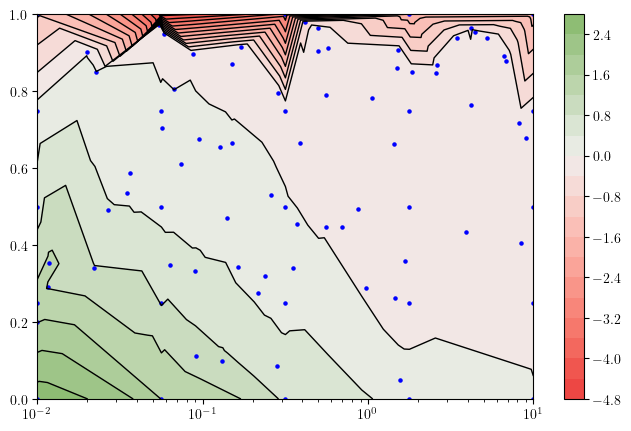

In [703]:
max1 = max(abs(bps1))

# Perform triangulation on log data
tri = Triangulation(np.log(q0_data), χinf_data)
tri.x = np.exp(tri.x)


fig, ax = plt.subplots(1, 1, figsize=(8,5))

im = plt.tricontourf(tri, bps1, levels=20, cmap=cc.cm['CET_D3_r'], vmin=-max1, vmax=max1)
plt.tricontour(tri, bps1, levels=20, colors='k', linewidths=1, linestyles='solid', vmin=-max1, vmax=max1)
# im = plt.tricontourf(tri, flux2_data, levels=15, cmap=cc.cm['CET_L12'], norm=colors.LogNorm())
# im = plt.tricontourf(tri, np.max(v_data, axis=1), levels=15, cmap=cc.cm['CET_L12'])
plt.scatter(q0_data, χinf_data, color='b', s=5)

plt.xscale('log')
plt.ylim(0, 1)

plt.colorbar(im)
plt.show()

In [149]:
q0 = 0.1
χinf = 0.1
rmax = 10
rmax_steps = 4

soln = wh.wormhole_T11(q0, χinf, rmax, rmax_steps, xatol=10**-14, quiet=True)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2sqr = soln

mask = (r > rmax/2)
poptφ, pcov = curve_fit(powerlaw4, r[mask]/q0, np.log(φ[mask]))
poptχ, pcov = curve_fit(powerlaw4, r[mask]/q0, np.log(χ[mask]))

Performing shooting method for q0 = 0.10 and χinf = 0.10 out to r = 10.00 ... DONE: val_final = 0


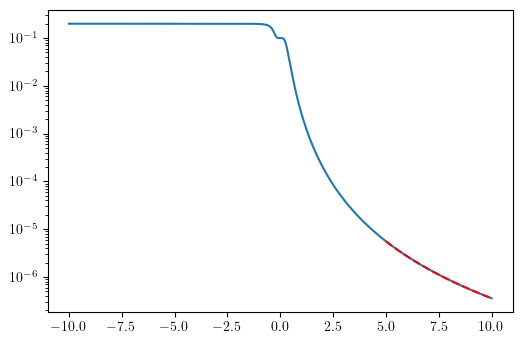

In [154]:
plt.plot(r, χinf - χ)
plt.plot(r[mask], χinf - np.exp(powerlaw4(r[mask]/q0, *poptχ)), '--r')

plt.yscale('log')

plt.show()

In [120]:
# q0s = np.geomspace(0.01, 10, 10)
q0_list = np.geomspace(0.1, 4, 5)
χ0p_list = [0, 0.1, 0.2]

q0s_ml = np.geomspace(0.7728, q0_list[-1], 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0_ml, v0_ml, φ0_ml, flux2_ml, hinf_ml = data_ml.T

q0s_fr = np.geomspace(q0_list[0], q0_list[-1], 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0_fr, v0_fr, φ0_fr, flux2_fr, hinf_fr = data_fr.T

data = []

for q0, χ0p in product(q0_list, χ0p_list):

    rmax = max(20, 10*q0)
    rmax_steps = 3
    soln = wh.wormhole_T11(q0, χ0p, rmax, rmax_steps, xatol=10**-16, nr=10000, quiet=True)
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, flux2 = soln

    mask = (r > rmax/2)
    popt, pcov = curve_fit(powerlaw4, r[mask]/q0, np.log(φ[mask]), [0, 1, 0])
    φ4 = popt[1] * q0**4
    
    if χ0p != 0:
        poptχ, pcov = curve_fit(powerlaw4, r[mask]/q0, np.log(χ[mask]), [0, 1, 0])
        χinf = poptχ[0]
        χ4 = poptχ[1] * q0**4
    else:
        χinf = 0
        χ4 = 0

    # It happens that u<0 and v,φ>0. Also save data for comparison with the BPS bound
    data.append([q0, χ0p, min(u), max(v), max(φ), flux2, φ4, χ4, χinf])

q0s, χ0ps, u0s, v0s, φ0s, flux2s, φ4s, χ4s, χinfs = np.asarray(data).T

Performing shooting method for q0 = 0.10 and χ0p = 0.00 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.10 and χ0p = 0.10 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.10 and χ0p = 0.20 out to r = 20.00 ... DONE: val_final = 0.008315847599
Performing shooting method for q0 = 0.25 and χ0p = 0.00 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.25 and χ0p = 0.10 out to r = 20.00 ... DONE: val_final = 0.001702836951
Performing shooting method for q0 = 0.25 and χ0p = 0.20 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.63 and χ0p = 0.00 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.63 and χ0p = 0.10 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 0.63 and χ0p = 0.20 out to r = 20.00 ... DONE: val_final = 0
Performing shooting method for q0 = 1.59 and χ0p = 0.00 out to r = 20.00 ... DONE: val_final = 0
Perf

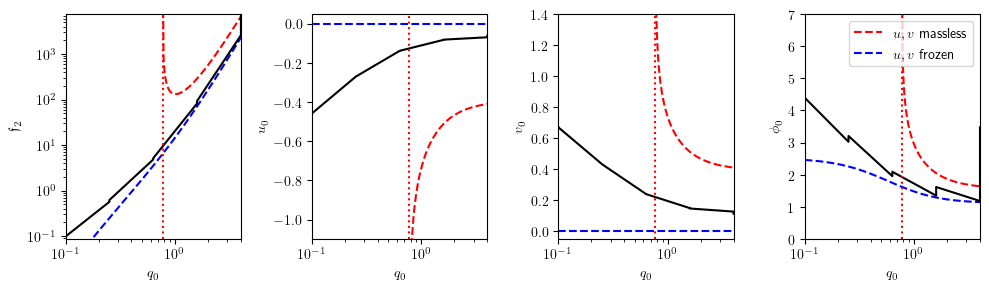

In [121]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True)

axes[0].plot(q0s_ml, flux2_ml, '--r')
axes[0].plot(q0s_fr, flux2_fr, '--b')
axes[0].plot(q0s,    flux2s,     'k')

axes[1].plot(q0s_ml, u0_ml, '--r')
axes[1].plot(q0s_fr, u0_fr, '--b')
axes[1].plot(q0s,    u0s,     'k')

axes[2].plot(q0s_ml, v0_ml, '--r')
axes[2].plot(q0s_fr, v0_fr, '--b')
axes[2].plot(q0s,    v0s,     'k')

axes[3].plot(q0s_ml, φ0_ml, '--r', label='$u,v$ massless')
axes[3].plot(q0s_fr, φ0_fr, '--b', label='$u,v$ frozen')
axes[3].plot(q0s,    φ0s,     'k')

for ax, ylab in zip(axes, ['$\mathfrak{f}_2$', '$u_0$', '$v_0$', '$\phi_0$']):
    ax.axvline(q0s_ml[0], ls=':', c='r')
    ax.set_xlabel('$q_0$')
    ax.set_ylabel(ylab)

plt.xlim(q0s[0], q0s[-1])
plt.xscale('log')

axes[0].set_yscale('log')
axes[0].set_ylim(min(flux2s), max(flux2s))
axes[1].set_ylim(-1.1, 0.05)
axes[2].set_ylim(-0.05, 1.4)
axes[3].set_ylim(0, 7)

axes[3].legend()

plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)
# plt.savefig('T11_ranges.png', dpi=300)
plt.show()

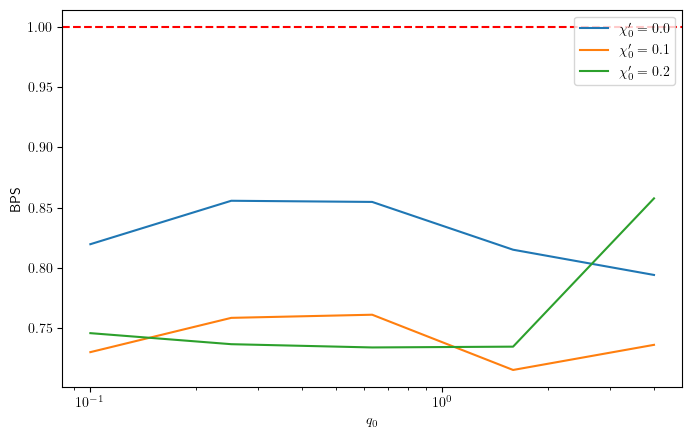

In [135]:
bps = 4*(φ4s+χ4s)/flux2s + χinfs

fig, ax = plt.subplots(1, 1, figsize=(8,5))

plt.axhline(1, ls='--', c='r')
for χ0p in np.unique(χ0ps):
    mask = (χ0ps == χ0p)
    plt.plot(q0s[mask], bps[mask], label='$\chi_0\'={}$'.format(χ0p))

plt.xlabel('$q_0$')
plt.ylabel('BPS')
plt.xscale('log')
# plt.ylim(0)

plt.legend()
plt.show()